In [ ]:
import pickle as pkl
from cgnet.molecule import CGMolecule
import mdtraj as md
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from importlib import reload

In [ ]:
embedding_map = {'ALA' : 1,
                'CYS' : 2,
                'ASP' : 3,
                'GLU' : 4,
                'PHE' : 5,
                'GLY' : 6,
                'HIS' : 7,
                'ILE' : 8,
                'LYS' : 9,
                'LEU' : 10,
                'MET' : 11,
                'ASN' : 12,
                'PRO' : 13,
                'GLN' : 14,
                'ARG' : 15,
                'SER' : 16,
                'THR' : 17,
                'VAL' : 18,
                'TRP' : 19,
                'TYR' : 20,
                'N' : 21,
                'CA' : 22,
                'C' : 23,
                'O' : 24}

embed2res = {value:key for key, value in embedding_map.items()}

In [3]:
# first we load the peptide dictionary and grab an MDtraj object 
peptide_dictionary = pkl.load(open('/net/data02/nickc/prior_force_generators/peptide_cg_meta_dictionary_no_physical_GLY_repul_fix.pkl', 'rb'))

In [4]:
# Here we make the CG Molecule 
print(peptide_dictionary[2])

{'residues': [GLN1, GLU2, MET3, GLY4, GLY5, GLY6, LEU7, GLU8], 'num_gly': 3, 'gly_idx': [3, 4, 5], 'gly_c_idx': [17, 21, 25], 'cg_atoms': [GLN1-N, GLN1-CA, GLN1-CB, GLN1-C, GLN1-O, GLU2-N, GLU2-CA, GLU2-CB, GLU2-C, GLU2-O, MET3-N, MET3-CA, MET3-CB, MET3-C, MET3-O, GLY4-N, GLY4-CA, GLY4-C, GLY4-O, GLY5-N, GLY5-CA, GLY5-C, GLY5-O, GLY6-N, GLY6-CA, GLY6-C, GLY6-O, LEU7-N, LEU7-CA, LEU7-CB, LEU7-C, LEU7-O, GLU8-N, GLU8-CA, GLU8-CB, GLU8-C, GLU8-O], 'cg_mapping_per_residue': ['N', 'CA', 'CB', 'C', 'O'], 'cg_indices': [0, 4, 6, 17, 18, 19, 21, 23, 32, 33, 34, 36, 38, 49, 50, 51, 53, 56, 57, 58, 60, 63, 64, 65, 67, 70, 71, 72, 74, 76, 89, 90, 91, 93, 95, 104, 105], 'num_all_atoms': 107, 'resmap': {1: 'GLN', 2: 'GLU', 3: 'MET', 4: 'GLY', 5: 'GLY', 6: 'GLY', 7: 'LEU', 8: 'GLU'}, 'resseq': [14, 14, 14, 14, 14, 4, 4, 4, 4, 4, 11, 11, 11, 11, 11, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 10, 10, 10, 10, 10, 4, 4, 4, 4, 4], 'res_idx': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 

In [5]:
from mlcg.geometry import *

In [6]:
num=2
embeddings = peptide_dictionary[num]['embeddings']
print(peptide_dictionary[num]['resmap'])
resseq = []
for n, res in enumerate(peptide_dictionary[num]['residues']):
    if res.name == 'GLY':
        for _ in range(4):
            resseq.append(n +1)
    else:
        for _ in range(5):
            resseq.append(n +1)
peptide_dictionary[num]['cg_molecule'] = CGMolecule(names=[atom.name for atom in peptide_dictionary[num]['cg_atoms']],
                                                    resseq=resseq,
                                                    resmap=peptide_dictionary[num]['resmap'],
                                                    bonds='standard')

{1: 'GLN', 2: 'GLU', 3: 'MET', 4: 'GLY', 5: 'GLY', 6: 'GLY', 7: 'LEU', 8: 'GLU'}


In [7]:
from mlcg.geometry.statistics import _symmetrise_angle_interaction, _symmetrise_distance_interaction

def get_n_pairs(connectivity_matrix, n=3, symmetrise=True):
    """This function uses networkx to identify those pairs
    that are exactly n atoms away.
    """
    graph = nx.Graph(connectivity_matrix.numpy())
    pairs = ([], [])
    for atom in graph.nodes:
        n_hop_paths = nx.single_source_dijkstra_path(graph, atom, cutoff=n)
        termini = [path[-1] for sub_atom, path in n_hop_paths.items() if len(path) == n]
        for child_atom in termini:
            sorted_pair = sorted((atom, child_atom))
            pairs[0].append(sorted_pair[0])
            pairs[1].append(sorted_pair[1])
            connections.append((sorted_pair[0], sorted_pair[1]))
            
    if symmetrise:
        pairs = _symmetrise_distance_interaction(torch.tensor(pairs))
    else:
        pairs = torch.tensor(pairs)
    return pairs


def get_n_paths(connectivity_matrix, n=3, symmetrise=True):
    """This function use networkx to grab all conencted paths defined
    by n connecting edges
    """
    
    if (n != 3 and n != 4) and symmetrise == True:
        raise NotImplementedError("Set symmetrise to False for n !=3/4.")
        
    graph = nx.Graph(connectivity_matrix.numpy())
    final_paths =  [ [] for i in range(n) ]
    for atom in graph.nodes:
        n_hop_paths = nx.single_source_dijkstra_path(graph, atom, cutoff=n)
        paths = [path for _ , path in n_hop_paths.items() if len(path) == n]
        #print(paths)
        for path in paths:
            #print(path)
            for k, sub_atom in enumerate(path):
                #print(sub_atom)
                final_paths[k].append(sub_atom)
    if symmetrise:
        if n == 3: final_paths = _symmetrise_angle_interaction(torch.tensor(final_paths))
        if n == 4: final_paths = _symmetrise_dihedral_interaction(torch.tensor(final_paths))
    else:
        final_paths = torch.tensor(final_paths)
    return final_paths


def get_connectivity_matrix(topology: Topology, directed: bool=False) -> torch.tensor:
    """Produces a full connectivity matrix from the bonded edge list"""

    if len(topology.bonds[0]) == 0 and len(topology.bonds[1]) == 0:
        raise ValueError("No bonds in the topology.")
    connectivity_matrix = torch.zeros((topology.n_atoms, topology.n_atoms))
    bonds = np.array(topology.bonds)
    if directed:
        for bond in range(bonds.shape[1]):
            connectivity_matrix[bonds[:, bond][0], bonds[:, bond][1]] = 1
    else:
        for bond in range(bonds.shape[1]):
            connectivity_matrix[bonds[:, bond][0], bonds[:, bond][1]] = 1
            connectivity_matrix[bonds[:, bond][1], bonds[:, bond][0]] = 1
    return connectivity_matrix

In [14]:
topo = Topology()
my_top = topo.from_mdtraj(peptide_dictionary[num]['cg_molecule'].topology)
my_top.types = embeddings
cmat = get_connectivity_matrix(my_top)
print(cmat.shape)
bonded_angles = get_n_paths(cmat,n=3)
bonded_dihedrals = get_n_paths(cmat,n=4,symmetrise=True)

full_graph = my_top.neighbor_list("fully connected")
bonds = my_top.neighbor_list("bonds")
for i in range(bonded_angles.shape[1]):
    a, b, c = bonded_angles[:,i].numpy()
    my_top.add_angle(a,b,c)
angles = my_top.neighbor_list("angles")
    
for ix in range(bonded_dihedrals.shape[1]):
    a, b, c, d = bonded_dihedrals[:,ix].numpy()
    my_top.add_dihedral(a,b,c,d)
dihedrals = my_top.neighbor_list("dihedrals")


print(full_graph)
print(bonds)
print(angles)
print(dihedrals)

torch.Size([37, 37])
{'tag': 'fully connected', 'order': 2, 'index_mapping': tensor([[ 0,  0,  0,  ..., 36, 36, 36],
        [ 1,  2,  3,  ..., 33, 34, 35]]), 'cell_shifts': None, 'rcut': None, 'self_interaction': False}
{'tag': 'bonds', 'order': 2, 'index_mapping': tensor([[ 1,  3,  1,  0,  3,  6,  8,  6,  5,  8, 11, 13, 11, 10, 13, 16, 17, 15,
         17, 20, 21, 19, 21, 24, 25, 23, 25, 28, 30, 28, 27, 30, 33, 35, 33, 32],
        [ 3,  4,  2,  1,  5,  8,  9,  7,  6, 10, 13, 14, 12, 11, 15, 17, 18, 16,
         19, 21, 22, 20, 23, 25, 26, 24, 27, 30, 31, 29, 28, 32, 35, 36, 34, 33]]), 'cell_shifts': None, 'rcut': None, 'self_interaction': False}
{'tag': 'angles', 'order': 3, 'index_mapping': tensor([[ 0,  0,  1,  1,  2,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10, 10, 11, 11,
         12, 13, 14, 15, 16, 16, 17, 18, 19, 20, 20, 21, 22, 23, 24, 24, 25, 26,
         27, 27, 28, 28, 29, 30, 31, 32, 32, 33, 34],
        [ 1,  1,  3,  3,  1,  5,  3,  6,  6,  8,  8,  6, 10,  8, 11, 11, 13, 13,

In [15]:
for i in range(bonds['index_mapping'].shape[1]):
    print(bonds['index_mapping'][:,i])

tensor([1, 3])
tensor([3, 4])
tensor([1, 2])
tensor([0, 1])
tensor([3, 5])
tensor([6, 8])
tensor([8, 9])
tensor([6, 7])
tensor([5, 6])
tensor([ 8, 10])
tensor([11, 13])
tensor([13, 14])
tensor([11, 12])
tensor([10, 11])
tensor([13, 15])
tensor([16, 17])
tensor([17, 18])
tensor([15, 16])
tensor([17, 19])
tensor([20, 21])
tensor([21, 22])
tensor([19, 20])
tensor([21, 23])
tensor([24, 25])
tensor([25, 26])
tensor([23, 24])
tensor([25, 27])
tensor([28, 30])
tensor([30, 31])
tensor([28, 29])
tensor([27, 28])
tensor([30, 32])
tensor([33, 35])
tensor([35, 36])
tensor([33, 34])
tensor([32, 33])


In [16]:
print(full_graph['index_mapping'])
print(bonds['index_mapping'])
print(angles['index_mapping'])

print(full_graph['index_mapping'].shape)
print(bonds['index_mapping'].shape)
print(angles['index_mapping'].shape)

full_map = full_graph['index_mapping']
bonds_map = bonds['index_mapping']
angles_map = angles['index_mapping']

tensor([[ 0,  0,  0,  ..., 36, 36, 36],
        [ 1,  2,  3,  ..., 33, 34, 35]])
tensor([[ 1,  3,  1,  0,  3,  6,  8,  6,  5,  8, 11, 13, 11, 10, 13, 16, 17, 15,
         17, 20, 21, 19, 21, 24, 25, 23, 25, 28, 30, 28, 27, 30, 33, 35, 33, 32],
        [ 3,  4,  2,  1,  5,  8,  9,  7,  6, 10, 13, 14, 12, 11, 15, 17, 18, 16,
         19, 21, 22, 20, 23, 25, 26, 24, 27, 30, 31, 29, 28, 32, 35, 36, 34, 33]])
tensor([[ 0,  0,  1,  1,  2,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10, 10, 11, 11,
         12, 13, 14, 15, 16, 16, 17, 18, 19, 20, 20, 21, 22, 23, 24, 24, 25, 26,
         27, 27, 28, 28, 29, 30, 31, 32, 32, 33, 34],
        [ 1,  1,  3,  3,  1,  5,  3,  6,  6,  8,  8,  6, 10,  8, 11, 11, 13, 13,
         11, 15, 13, 16, 17, 17, 19, 17, 20, 21, 21, 23, 21, 24, 25, 25, 27, 25,
         28, 28, 30, 30, 28, 32, 30, 33, 33, 35, 33],
        [ 2,  3,  4,  5,  3,  6,  5,  7,  8,  9, 10,  8, 11, 10, 12, 13, 14, 15,
         13, 16, 15, 17, 18, 19, 20, 19, 21, 22, 23, 24, 23, 25, 26, 27, 28, 27

In [17]:
# Here we need to subtract all physical bonds and all 1-3 distances
# first the bonds
non_bonds = ([], [])
for i in range(full_map.shape[1]):
    pair = full_map[:,i]
    #print(pair)
    one_three = False
    bonded = False
    for k in range(angles_map.shape[1]):
        angle = angles_map[:,k]
        if pair[0] == angle[0] and pair[1] == angle[2]:
            one_three = True
            break
        if pair[0] == angle[2] and pair[1] == angle[0]:
            one_three = True
            break
    for k in range(bonds_map.shape[1]):
        bond = bonds_map[:,k]
        if pair[0] == bond[0] and pair[1] == bond[1]:
            bonded = True
            break
        if pair[0] == bond[1] and pair[1] == bond[0]:
            bonded = True
            break
    if one_three == False and bonded == False:
        pair = sorted(pair)
        non_bonds[0].append(int(pair[0]))
        non_bonds[1].append(int(pair[1]))
non_bonds = torch.tensor(non_bonds)
non_bonds = _symmetrise_distance_interaction(non_bonds)
print(non_bonds.shape)

torch.Size([2, 583])


In [18]:
for i in range(non_bonds.shape[1]):
    print(non_bonds[:,i])

tensor([0, 4])
tensor([0, 5])
tensor([0, 6])
tensor([0, 7])
tensor([0, 8])
tensor([0, 9])
tensor([ 0, 10])
tensor([ 0, 11])
tensor([ 0, 12])
tensor([ 0, 13])
tensor([ 0, 14])
tensor([ 0, 15])
tensor([ 0, 16])
tensor([ 0, 17])
tensor([ 0, 18])
tensor([ 0, 19])
tensor([ 0, 20])
tensor([ 0, 21])
tensor([ 0, 22])
tensor([ 0, 23])
tensor([ 0, 24])
tensor([ 0, 25])
tensor([ 0, 26])
tensor([ 0, 27])
tensor([ 0, 28])
tensor([ 0, 29])
tensor([ 0, 30])
tensor([ 0, 31])
tensor([ 0, 32])
tensor([ 0, 33])
tensor([ 0, 34])
tensor([ 0, 35])
tensor([ 0, 36])
tensor([1, 6])
tensor([1, 7])
tensor([1, 8])
tensor([1, 9])
tensor([ 1, 10])
tensor([ 1, 11])
tensor([ 1, 12])
tensor([ 1, 13])
tensor([ 1, 14])
tensor([ 1, 15])
tensor([ 1, 16])
tensor([ 1, 17])
tensor([ 1, 18])
tensor([ 1, 19])
tensor([ 1, 20])
tensor([ 1, 21])
tensor([ 1, 22])
tensor([ 1, 23])
tensor([ 1, 24])
tensor([ 1, 25])
tensor([ 1, 26])
tensor([ 1, 27])
tensor([ 1, 28])
tensor([ 1, 29])
tensor([ 1, 30])
tensor([ 1, 31])
tensor([ 1, 32])


In [19]:
import networkx as nx
from networkx.algorithms.traversal.depth_first_search import *
import matplotlib

In [20]:
my_graph = nx.Graph(cmat.numpy())

Graph with 37 nodes and 36 edges


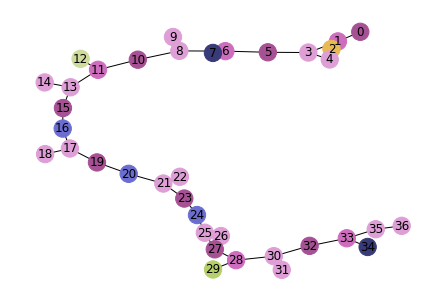

In [21]:
print(my_graph)
labels = [str(i) for i in my_graph.nodes]
labels = {int(i):i for i in labels}
positions = nx.spring_layout(my_graph, seed=0)
nx.draw(my_graph, pos=positions, node_color=embeddings, labels=labels, cmap=matplotlib.cm.tab20b)


In [23]:
pairs_1_4 = get_n_pairs(cmat, n=4)
print(pairs_1_4.shape)
connections = []
for i in pairs_1_4.t():
    pair = i.numpy()
    connections.append((pair[0],pair[1]))

NameError: name 'connections' is not defined

In [24]:
graph_1_4 = nx.Graph(connections)

NameError: name 'connections' is not defined

Graph with 37 nodes and 36 edges


NameError: name 'graph_1_4' is not defined

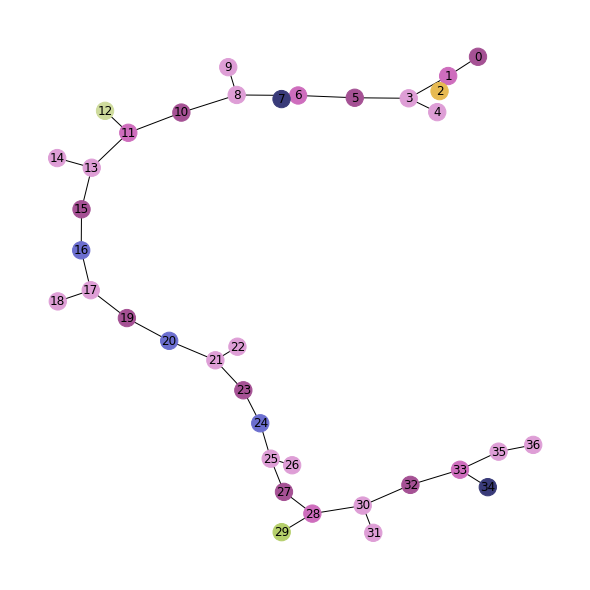

In [25]:
print(my_graph)
fig=plt.figure(figsize=(8,8))
labels = [str(i) for i in my_graph.nodes]
labels = {int(i):i for i in labels}
positions = nx.spring_layout(my_graph, seed=0)
nx.draw(my_graph, pos=positions, node_color=embeddings, labels=labels, cmap=matplotlib.cm.tab20b)
nx.draw_networkx_edges(graph_1_4, pos=positions, edge_color='red')

In [26]:
from mlcg.data import *
from torch_geometric.data.collate import collate
from mlcg.geometry import *

In [27]:
# Next, we need to load the opep data, get some statistics, and fit some priors
coords = np.load('/net/data02/nickc/octapeptides/brooke_map_cg_data/opep_0002_cg_coords_no_physical_GLY_repul_fix.npy'.format(num))  
print(coords.shape)
print(len(embeddings))

prior_nls = {'bonds':bonds, 'angles':angles, 'dihedrals':dihedrals}

data_list = []
for i in range(coords.shape[0]):
    data_list.append(AtomicData.from_points(pos=torch.tensor(coords[i]),
                                            atom_types=torch.tensor(embeddings), 
                                            neighborlist=prior_nls))

print(data_list[-1])
print(data_list[-1]['atom_types'])

(20800, 37, 3)
37
AtomicData(
  pos=[37, 3],
  atom_types=[37],
  n_atoms=[1],
  neighbor_list={
    bonds={
      tag='bonds',
      order=2,
      index_mapping=[2, 36],
      cell_shifts=None,
      rcut=None,
      self_interaction=False
    },
    angles={
      tag='angles',
      order=3,
      index_mapping=[3, 47],
      cell_shifts=None,
      rcut=None,
      self_interaction=False
    },
    dihedrals={
      tag='dihedrals',
      order=4,
      index_mapping=[4, 49],
      cell_shifts=None,
      rcut=None,
      self_interaction=False
    }
  },
  out={}
)
tensor([21, 22, 14, 23, 24, 21, 22,  4, 23, 24, 21, 22, 11, 23, 24, 21,  6, 23,
        24, 21,  6, 23, 24, 21,  6, 23, 24, 21, 22, 10, 23, 24, 21, 22,  4, 23,
        24])


In [28]:
datas, slices, _ = collate(
    data_list[0].__class__,
    data_list=data_list,
    increment=True,
    add_batch=True,
)

In [29]:
print(datas)
print(datas.n_atoms)
print(datas.neighbor_list.keys())
print(datas['atom_types'])

AtomicData(
  out={},
  pos=[769600, 3],
  atom_types=[769600],
  n_atoms=[20800],
  neighbor_list={
    bonds={
      tag=[20800],
      order=[20800],
      index_mapping=[2, 748800],
      cell_shifts=[20800],
      rcut=[20800],
      self_interaction=[20800]
    },
    angles={
      tag=[20800],
      order=[20800],
      index_mapping=[3, 977600],
      cell_shifts=[20800],
      rcut=[20800],
      self_interaction=[20800]
    },
    dihedrals={
      tag=[20800],
      order=[20800],
      index_mapping=[4, 1019200],
      cell_shifts=[20800],
      rcut=[20800],
      self_interaction=[20800]
    }
  },
  batch=[769600],
  ptr=[20801]
)
tensor([37, 37, 37,  ..., 37, 37, 37])
dict_keys(['bonds', 'angles', 'dihedrals'])
tensor([21, 22, 14,  ...,  4, 23, 24])


In [30]:
from copy import deepcopy
from mlcg.utils import tensor2tuple
from scipy.integrate import trapezoid

def _symmetrise_distance_interaction(unique_interaction_types):
    """Distance based interactions are symmetric w.r.t. the direction hence
    the need for only considering interactions (a,b) with a < b.
    """
    mask = unique_interaction_types[0] > unique_interaction_types[1]
    ee = unique_interaction_types[0, mask]
    unique_interaction_types[0, mask] = unique_interaction_types[1, mask]
    unique_interaction_types[1, mask] = ee
    unique_interaction_types = torch.unique(unique_interaction_types, dim=1)
    return unique_interaction_types


def _symmetrise_angle_interaction(unique_interaction_types):
    """For angles defined as::
      2---3
     /
    1
    atom 1 and 3 can be exchanged without changing the angle so the resulting
    interaction is symmetric w.r.t such transformations. Hence the need for only
    considering interactions (a,b,c) with a < c.
    """
    mask = unique_interaction_types[0] > unique_interaction_types[2]
    ee = unique_interaction_types[0, mask]
    unique_interaction_types[0, mask] = unique_interaction_types[2, mask]
    unique_interaction_types[2, mask] = ee
    unique_interaction_types = torch.unique(unique_interaction_types, dim=1)
    return unique_interaction_types


def _symmetrise_dihedral_interaction(unique_interaction_types):
    """For dihedrals defined as::
      2---3---4
     /
    1
    atoms [(1,2,3,4),(4,3,2,1) can be exchanged without changing the dihedral 
    so the resulting interaction is symmetric w.r.t such transformations. 
    Hence the need for only considering interactions (a,b,c,d) with a < d.
    """
    mask = unique_interaction_types[0] > unique_interaction_types[3]
    ee0 = unique_interaction_types[0, mask]
    ee1 = unique_interaction_types[1, mask]
    ee2 = unique_interaction_types[2, mask]
    ee3 = unique_interaction_types[3, mask]
    unique_interaction_types[0, mask] = ee3
    unique_interaction_types[1, mask] = ee2
    unique_interaction_types[2, mask] = ee1
    unique_interaction_types[3, mask] = ee0
    unique_interaction_types = torch.unique(unique_interaction_types, dim=1)
    return unique_interaction_types



_symmetrise_map = {
    2: _symmetrise_distance_interaction,
    3: _symmetrise_angle_interaction,
    4: _symmetrise_dihedral_interaction,
}

_flip_map = {
    2: lambda tup: torch.tensor([tup[1], tup[0]], dtype=torch.long),
    3: lambda tup: torch.tensor([tup[2], tup[1], tup[0]], dtype=torch.long),
    4: lambda tup: torch.tensor([tup[3], tup[2], top[1], tup[0]], dtype=torch.long),
}


def _get_all_unique_keys(unique_types, order):
    # get all combinations of size order between the elements of unique_types
    keys = torch.cartesian_prod(*[unique_types for ii in range(order)]).t()
    # symmetrize the keys and keep only unique entries
    sym_keys = _symmetrise_map[order](keys)
    unique_sym_keys = torch.unique(sym_keys, dim=1)
    return unique_sym_keys


def _get_bin_centers(a, nbins):
    bin_centers = torch.zeros((nbins,), dtype=torch.float64)
    a_min = a.min()
    a_max = a.max()
    delta = (a_max - a_min) / nbins
    bin_centers = (
        a_min
        + 0.5 * delta
        + torch.arange(0, nbins, dtype=torch.float64) * delta
    )
    return bin_centers


def compute_statistics(
    data: AtomicData,
    target: str,
    beta: float,
    TargetPrior: _Prior = Harmonic,
    nbins: int = 100,
):
    """TODO add doc"""

    unique_types = torch.unique(data.atom_types)
    order = data.neighbor_list[target]["index_mapping"].shape[0]
    unique_keys = _get_all_unique_keys(unique_types, order)

    mapping = data.neighbor_list[target]["index_mapping"]
    values = TargetPrior.compute_features(data.pos, mapping)

    interaction_types = torch.vstack(
        [data.atom_types[mapping[ii]] for ii in range(order)]
    )
    print(interaction_types)
    print(unique_keys)

    statistics = {}
    for unique_key in unique_keys.t():
        # find which values correspond to unique_key type of interaction
        mask = torch.all(
            torch.vstack(
                [
                    interaction_types[ii, :] == unique_key[ii]
                    for ii in range(order)
                ]
            ),
            dim=0,
        )
        print(unique_key, values)
        val = values[mask]
        if len(val) == 0:
            print(unique_key, 'TROUBLE')
            continue

        bin_centers = _get_bin_centers(val, nbins)
        hist = torch.histc(val, bins=nbins)

        mask = hist > 0
        bin_centers_nz = bin_centers[mask]
        ncounts_nz = hist[mask]
        dG_nz = -torch.log(ncounts_nz) / beta
        params = TargetPrior.fit_from_potential_estimates(bin_centers_nz, dG_nz)
        kk = tensor2tuple(unique_key)
        statistics[kk] = params

        statistics[kk]["p"] = hist / trapezoid(
            hist.cpu().numpy(), x=bin_centers.cpu().numpy()
        )
        statistics[kk]["p_bin"] = bin_centers
        statistics[kk]["V"] = dG_nz
        statistics[kk]["V_bin"] = bin_centers_nz

        kf = tensor2tuple(_flip_map[order](unique_key))
        statistics[kf] = deepcopy(statistics[kk])

    return statistics

In [31]:
def compute_dihedral_statistics(
    data: AtomicData,
    target: str,
    beta: float,
    TargetPrior: _Prior = Dihedral,
    nbins: int = 100,
):
    """TODO add doc"""

    unique_types = torch.unique(data.atom_types)
    order = data.neighbor_list[target]["index_mapping"].shape[0]
    unique_keys = _get_all_unique_keys(unique_types, order)

    mapping = data.neighbor_list[target]["index_mapping"]
    print(mapping, TargetPrior)
    values = TargetPrior.compute_features(data.pos, mapping)
    print(values)

    interaction_types = torch.vstack(
        [data.atom_types[mapping[ii]] for ii in range(order)]
    )
    print(interaction_types)
    print(unique_keys)

    statistics = {}
    for unique_key in unique_keys.t():
        # find which values correspond to unique_key type of interaction
        mask = torch.all(
            torch.vstack(
                [
                    interaction_types[ii, :] == unique_key[ii]
                    for ii in range(order)
                ]
            ),
            dim=0,
        )
        print(unique_key, values)
        val = values[mask]
        if len(val) == 0:
            print(unique_key, 'TROUBLE')
            continue

        bin_centers = _get_bin_centers(val, nbins)
        hist = torch.histc(val, bins=nbins)

        mask = hist > 0
        bin_centers_nz = bin_centers[mask]
        ncounts_nz = hist[mask]
        dG_nz = -torch.log(ncounts_nz) / beta
        params = TargetPrior.fit_from_potential_estimates(bin_centers_nz, dG_nz)
        kk = tensor2tuple(unique_key)
        statistics[kk] = params

        statistics[kk]["p"] = hist / trapezoid(
            hist.cpu().numpy(), x=bin_centers.cpu().numpy()
        )
        statistics[kk]["p_bin"] = bin_centers
        statistics[kk]["V"] = dG_nz
        statistics[kk]["V_bin"] = bin_centers_nz

        kf = tensor2tuple(_flip_map[order](unique_key))
        statistics[kf] = deepcopy(statistics[kk])

    return statistics

In [32]:
import copy
data = copy.deepcopy(datas)

In [33]:
mapping = datas.neighbor_list['dihedrals']["index_mapping"]

In [52]:
def compute_dihedrals(pos: torch.Tensor, mapping: torch.Tensor):
    assert mapping.dim() == 2
    assert mapping.shape[0] == 4
    dr1 = pos[mapping[1]]-pos[mapping[0]]
    dr2 = pos[mapping[2]]-pos[mapping[1]]
    dr3 = pos[mapping[3]]-pos[mapping[2]]
    dr1 = dr1/dr1.norm(p=2,dim=1)
    dr2 = dr2/dr2.norm(p=2,dim=1)
    dr3 = dr3/dr3.norm(p=2,dim=1)

    n1 = torch.cross(dr1,dr2)
    n2 = torch.cross(dr2,dr3)
    m1 = torch.cross(n1,dr2)
    y = torch.dot(m1,n2)
    x = torch.dot(n1,n2)
    theta = torch.atan2(y,x)

    return theta

In [40]:
pos = copy.deepcopy(data.pos)

In [56]:
dr1.shape,dr1.norm(p=2,dim=1).shape

(torch.Size([1019200, 3]), torch.Size([1019200]))

In [62]:
dr1, 1.35/1.5494

(tensor([[ 1.3500, -0.7600, -0.0200],
         [ 1.3500, -0.7600, -0.0200],
         [ 1.1000,  1.0400, -0.1500],
         ...,
         [-1.0500,  0.2800,  0.4800],
         [ 0.2500, -1.4600, -0.1800],
         [-0.8400,  0.5400, -1.2100]]),
 0.8713050212985671)

In [60]:
dr1.norm(p=2,dim=1)

tensor([1.5494, 1.5494, 1.5212,  ..., 1.1880, 1.4921, 1.5689])

In [59]:
# dr1 = torch.div(dr1,dr1.norm(p=2,dim=1))
dr1 / dr1.norm(p=2,dim=1)[:,None]

tensor([[ 0.8713, -0.4905, -0.0129],
        [ 0.8713, -0.4905, -0.0129],
        [ 0.7231,  0.6837, -0.0986],
        ...,
        [-0.8839,  0.2357,  0.4040],
        [ 0.1675, -0.9785, -0.1206],
        [-0.5354,  0.3442, -0.7713]])

In [73]:
dr1 = pos[mapping[1]]-pos[mapping[0]]
dr2 = pos[mapping[2]]-pos[mapping[1]]
dr3 = pos[mapping[3]]-pos[mapping[2]]
dr1 = dr1 / dr1.norm(p=2,dim=1)[:,None]
dr2 = dr2 / dr2.norm(p=2,dim=1)[:,None]
dr3 = dr3 / dr3.norm(p=2,dim=1)[:,None]

n1 = torch.cross(dr1,dr2,dim=1)
n2 = torch.cross(dr2,dr3,dim=1)
m1 = torch.cross(n1,dr2,dim=1)
y = torch.sum(m1*n2,dim=-1)
x = torch.sum(n1*n2,dim=-1)
theta = torch.atan2(y,x)

In [75]:
theta*180/3.1415

tensor([  38.1719, -133.3607,  176.9135,  ...,   13.2417,   49.5089,
         -77.3906])

In [36]:
m1 = mapping[1]
m2 = mapping[]

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [34]:
Dihedral.compute_features(data.pos,mapping)

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/clarkt/research/mlcg-tools/mlcg/geometry/internal_coordinates.py", line 152, in compute_dihedrals
    n2 = torch.cross(dr2,dr3)
    m1 = torch.cross(n1,dr2)
    y = torch.dot(m1,n2)
        ~~~~~~~~~ <--- HERE
    x = torch.dot(n1,n2)
    theta = torch.atan2(y,x)
RuntimeError: 1D tensors expected, but got 2D and 2D tensors


In [12]:
from mlcg.nn.prior import _Prior, Harmonic, HarmonicBonds, HarmonicAngles, Dihedral
temperature = 350  # K
#:Boltzmann constan in kcal/mol/K
kB = 0.0019872041
beta = (1/(temperature*kB))

# bond_stats = compute_statistics(datas, 'bonds', beta=beta, TargetPrior=HarmonicBonds)
# angle_stats = compute_statistics(datas, 'angles', beta=beta, TargetPrior=HarmonicAngles)
dihedral_stats = compute_dihedral_statistics(datas, 
                                             'dihedrals',
                                             beta=beta,
                                             TargetPrior=Dihedral)

NameError: name 'compute_dihedral_statistics' is not defined

In [ ]:
print(bond_stats.keys())
print(bond_stats)

In [ ]:
for key in bond_stats.keys():
    print(key)
    name = str(embed2res[key[0]] + " - " + embed2res[key[1]])
    p = bond_stats[key]['p'].numpy()
    bins = bond_stats[key]['p_bin'].numpy()
    plt.step(bins,p,where='mid',linestyle='-', label=str(name))
plt.legend(loc='best')
plt.show()

In [ ]:
print(angle_stats.keys())
print(angle_stats)

In [ ]:
for key in angle_stats.keys():
    name = str(embed2res[key[0]] + " - " + embed2res[key[1]] + " - " + embed2res[key[2]] )
    p = angle_stats[key]['p'].numpy()
    bins = angle_stats[key]['p_bin'].numpy()
    plt.step(bins,p,where='mid',linestyle='-', label=name)
plt.legend(loc='best')
plt.show()

In [ ]:
print(dihedral_stats.keys())
print(dihedral_stats)